# 6. Variational Autoencoder

We have seen approaches for compression previously. In this notebook, we cover a related
approach based on neural networks which also enables us to generate novel (artificial) data. 

In particular, we discuss 

* latent variable models and
* the Variational Autoencoder

and provide a more advanced CNN implementation for MNIST and a molecule dataset.  

Keywords: ```VAE```, ```ELBO```, ```reparameterisation trick```, ```keras.Model```, ```keras.layers.Conv2DTranspose```,
```tensorflow.GradientTape```, ```tf.sigmoid```, ```model.save_weights```, ```model.load_weights```, ```keras.optimizers.Adam```

***

## Latent Variable Models

Latent variable models (LVMs) are statistical models which consider random variables.
Suppose that our observations $X$ and $Y$ are random variables following a probability 
distribution $p(X,Y)$. LVMs assume that there are **latent, i.e. unobserved or hidden, variables** $Z$
which have a relationship to our observed data $X$ and $Y$. A typical assumption, for instance is,
that our predictors $X$ are generated by **lower-dimensional latent variables** $Z$, e.g. $p(X \mid Z)$. 

Note that we have seen models such as these already. For example, in a **Gaussian Mixture Model** datapoints $X_i$ belonging to cluster $i$ with mean $\mu_i$ and covariance matrix $\Sigma_i$ are generated by sampling from
$\mathcal{N}(\mu_i, \Sigma_i)$. In other words, the low-dimensional latent variables are $Z=(\mu, \Sigma)$. **PCA** is another example where few principal components can allow describing the majority of variation in a dataset. However, these **linear LVMs** assume linear relationships between latent variable $Z$ and the observations.

Due to the highly non-linear nature of neural networks, we can use neural networks to extend models such as PCA to
**non-linear LVMs**. Here, we pick up the previously encountered idea of compression:

<br><center><img src="images/Compression.png" alt="Image compression with Fast Fourier Transform" width="600"/></center></br>

The **Variational Autoencoder (VAE)** is an unsupervised neural network approach which attempts to identify a
meaningful **latent representation** $Z$ capable of reconstructing the original input as perfectly as possible. 
The VAE can be viewed as probabilistic non-linear PCA, with the general idea being illustrated in the following figure.

<center><img src="images/VAE_idea.png" alt="Variational Autoencoder Illustration" width="400"/></center>

The VAE has three important components:

1. **Enocoder**: The encoder neural network attempts to compress the relevant information about $X$ in latent representation $Z$ with dimensions $d_X > d_Z$. The goal of the encoder is to parameterise a distribution $q_\phi (Z \mid X)$ which provides us a (variational) approximation for the distribution of the (compressed) latent variables $Z$ given an input $X$. Here, $\phi$ denotes the weights of the encoder network. We typically assume that this approximation is given by a Gaussian distribution $\mathcal{N} (\mu_Z,\Sigma_Z)$ where $\mu_Z=(\mu_1, \dots, \mu_{d_Z})$ and $\Sigma_Z=(\sigma_1, \dots, \sigma_{d_Z})$ containing only the diagonal entries of covariance matrix $\Sigma_Z$ (all other entries are 0). For technical reasons (details omitted), we require the **reparameterisation trick** to sample latent variables $Z$: $$z_n( \varepsilon ) = \mu_{Z}(x_n) + \Sigma^2_{Z}(x_n)  \varepsilon$$ with $\varepsilon\sim\mathcal{N}(0,1)$.

2. **Latent representation / space** $Z$: Datapoints from the input space are mapped into the lower-dimensional latent space $Z$. To start with, we typically assume that the latent variables $Z$ are normally distributed, i.e. a prior distribution $p(Z) = \mathcal{N} (0,\mathbb{1}_{d_Z})$ with $d_Z$ being the number of latent dimensions. We train the encoder such that the (posterior) distribution $q_\phi (Z \mid X)$ matches the prior $p(Z)$ as much as possible. The deviations from the prior distribution will capture important features of our dataset. We measure the difference in these distributions with the (non-negative) [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) $$D_\text{KL} \big(q_{\phi}(Z \mid X) \Vert p(Z) \big) = - \frac{1}{2} \sum_{i=1}^{d_Z} (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2),$$ where the last expression follows from the Gaussian distrubtion assumptions outlined before.

3. **Decoder**: The decoder neural network attempts so reconstruct the original input $X$ from the compressed representation $Z$. The goal of the decoder is to parameterise the likelihood $p_\theta (X \mid Z)$ with decoder network weights $\theta$. The **reconstruction error** is measured by the log-likelihood $\log (p_\theta (X \mid Z))$ which in the case of regression tasks is typically given by the mean-squared error loss and in classification tasks by the cross-entropy loss.

Combining these ingredients, we obtain the VAE loss function which is usually referred to as negative **evidence lower bound (ELBO)**

\begin{equation}
   \text{Loss} (\phi, \theta)= \frac{1}{s} \sum_{i=1}^{s} \underbrace{\mathbb{E}_{q_{\phi} (z \vert x_i)} \big(- \log (p_{\theta}(x_i \vert z)) \big)}_\text{reconstruction loss} + \underbrace{D_\text{KL} \big( q_{\phi}(z \vert x_i) \Vert p(z) \big)}_\text{latent loss}
\end{equation}

where $s$ is the batch size (denoting that we sum the results for different batches). Note that the VAE objective has two parts which we try to balance:

1. The **reconstruction loss** measures how well we can reconstruct the input $X$ from the compression $Z$. In other words, this term is an incentive to provide as much information of $X$ in $Z$ as possible, i.e. less compression.
2. The **latent loss** measures how well the posterior $q_{\phi}(Z \mid X)$ agrees with the prior $p(Z)$. This term favours stronger compressions.

With this probabilistic framework, we can now explore the latent space $Z$ and, in particular, pick
latent points in $Z$ to generate novel artifical objects by decoding the picked latent point!

Let's implement and apply a VAE on MNIST! For this, we first define 
a class for the model which provides the individual parts as outlined above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

class VAE(keras.Model):

    def __init__(self, latent_dim, batch_size):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
        # Encoder network:
        self.encoder = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(28, 28, 1)),
                keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                keras.layers.Flatten(),
                keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        # Decoder network:
        self.decoder = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(latent_dim,)),
                keras.layers.Dense(units=7 * 7 * 32, activation='relu'),
                keras.layers.Reshape(target_shape=(7, 7, 32)),
                keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

        
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    
    # Reparameterisation trick:
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean
    
    
    def call(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

2023-03-24 13:15:39.884475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Furthermore, we define some functions we will use for computing the loss and 
the training steps. Note that in the previous notebook we used some built-in
```keras``` functions for that.

In [2]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Now, we can load MNIST as before.

In [3]:
mnist_data = np.load('data/mnist_data_5k.npy', allow_pickle=True).astype('float32')
mnist_targets = np.load('data/mnist_labels_5k.npy', allow_pickle=True).astype('float32')

mnist_data = mnist_data.reshape(-1, 28, 28, 1) / 255

num_train = 3000
num_val = 1000
num_test = 1000

x_train = mnist_data[:num_train]
y_train = mnist_targets[:num_train]

x_val = mnist_data[num_train:num_train+num_val]
y_val = mnist_targets[num_train:num_train+num_val]

x_test = mnist_data[-num_test:]
y_test = mnist_targets[-num_test:]

Define the hyperparameters, the model, and the optimiser, where we choose the [Adam optimiser](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) this time.

In [4]:
learning_rate = 0.0001
batch_size = 64
num_epochs = 20
latent_dim = 2

vae_model = VAE(latent_dim, batch_size)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

2023-03-24 13:15:45.891703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In the following, we write our own loop for training and validation.

**For Noto users**: Please note that the training can take several minutes on Noto!

In [5]:
for epoch in range(1, num_epochs + 1):

    # Training steps
    for i in range(num_train // batch_size):
        train_step(vae_model, x_train[i:i + batch_size], optimizer)

    # Validation steps
    r_val = num_val // batch_size
    loss = keras.metrics.Mean()
    elbo = 0

    for i in range(r_val):
        loss(compute_loss(vae_model, x_val[i:i + batch_size]))
        elbo += -loss.result()

    elbo /= r_val

    print(f'Epoch: {epoch}/{num_epochs}, validation loss (ELBO): {elbo}')

Epoch: 1/20, validation loss (ELBO): -529.894775390625
Epoch: 2/20, validation loss (ELBO): -455.3930358886719
Epoch: 3/20, validation loss (ELBO): -335.8797912597656
Epoch: 4/20, validation loss (ELBO): -285.97296142578125
Epoch: 5/20, validation loss (ELBO): -251.6230010986328
Epoch: 6/20, validation loss (ELBO): -234.57460021972656
Epoch: 7/20, validation loss (ELBO): -225.56549072265625
Epoch: 8/20, validation loss (ELBO): -220.42120361328125
Epoch: 9/20, validation loss (ELBO): -217.3555145263672
Epoch: 10/20, validation loss (ELBO): -215.20712280273438
Epoch: 11/20, validation loss (ELBO): -212.9918975830078
Epoch: 12/20, validation loss (ELBO): -211.4029998779297
Epoch: 13/20, validation loss (ELBO): -209.53585815429688
Epoch: 14/20, validation loss (ELBO): -207.47470092773438
Epoch: 15/20, validation loss (ELBO): -206.21136474609375
Epoch: 16/20, validation loss (ELBO): -205.02468872070312
Epoch: 17/20, validation loss (ELBO): -203.96925354003906
Epoch: 18/20, validation loss (

For our custom model, we need to store the trained weights in the following way:

In [6]:
vae_model.save_weights('output/MNIST_VAE.h5', save_format='h5')

You can load a pretrained model like this:

In [7]:
vae_model = VAE(latent_dim, num_test)
vae_model(x_test)  # For input dimension specification

# Our pretrained model (300 epochs):
vae_model.load_weights('output/MNIST_VAE_pretrained.h5')

# ... or load your model:
# vae_model.load_weights('output/MNIST_VAE.h5')

Let's check out the results for the test data.

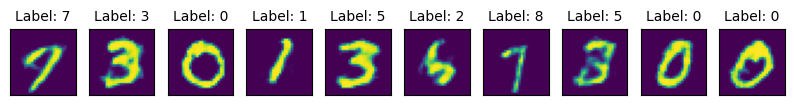

In [8]:
mean_z, logvar_z = vae_model.encode(x_test)
latent_z = vae_model.reparameterize(mean_z, logvar_z)
predictions = vae_model.sample(latent_z)

fig, axs = plt.subplots(1,10, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(predictions[i])
    
    ax.set_title(f"Label: {int(y_test[i])}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

We can also investigate where the test datapoints lie in the latent space.

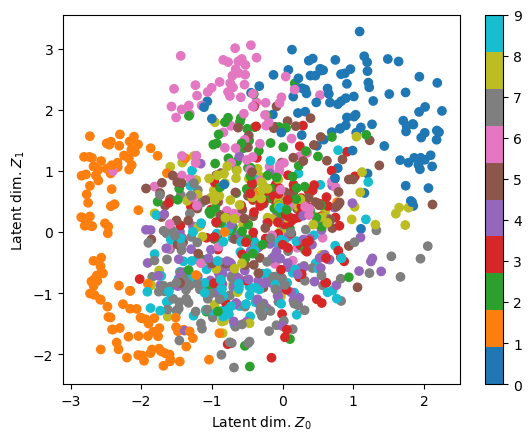

In [9]:
plt.scatter(latent_z[:, 0], latent_z[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.xlabel(r"Latent dim. $Z_0$")
plt.ylabel(r"Latent dim. $Z_1$")
plt.show()

***

## Variational Autoencoder for Molecules
 
*(Note that in this part you might not be able to execute all cells -- in particular on Noto!)*

In the following we apply the VAE-idea on a molecular dataset and train a **Chemical VAE**. In addition to the standard VAE, we also predict a chemical property $Y$. This allow us to do a **guided search of novel molecules** which match a property of our interest.

<center><img src="images/Molecule_example.png" alt="VAE for Molecules" width="400"/></center>

As illustrated above, we predict a chemical property with an **additional decoder network** directly from the latent sample. This does not only provide additional information about the molecules, but also structures the latent representation $Z$ with resprect to property $Y$. This will have the effect the chemical property will gradually change within the latent space.


So far, we have worked with tabular data and images as inputs. Molecules can be represented in variouse ways. A common representation is a graph. Here, the nodes of a molecular graph are the atoms and the edges are molecular bonds. A popular and simple depiction of a molecular graph is a so-called **SMILES representation**. It is a text string that encloses all the information required to convert it to a graph.

For our experiments we will use a variant called the **Deep-SMILES representation** which makes generation of valid molecular structures easier.

Let's have a closer look on the dataset and how these SMILES and Deep-SMILES look like.

In [10]:
import pandas as pd
import numpy as np

molecule_data = pd.read_pickle('data/molecule_data.pkl')
molecule_data

,id,smiles,deep_smiles,band_gap
0,2,N,N,0.3399
1,3,O,O,0.3615
2,4,C#C,C#C,0.3351
3,7,CC,CC,0.4426
4,8,CO,CO,0.3437
...,...,...,...,...
31667,41529,C1CC2=CCCOCC12,CCC=CCCOCC97,0.2548
31668,41530,C1CC2=CCOCCC12,CCC=CCOCCC97,0.2528
31669,41531,C1CC2=CCOCOC12,CCC=CCOCOC97,0.2504
31670,41533,C1OC2=NCCCCC12,COC=NCCCCC97,0.2701


We can now plot the first and the last molecules from the dataset as chemical graphs.

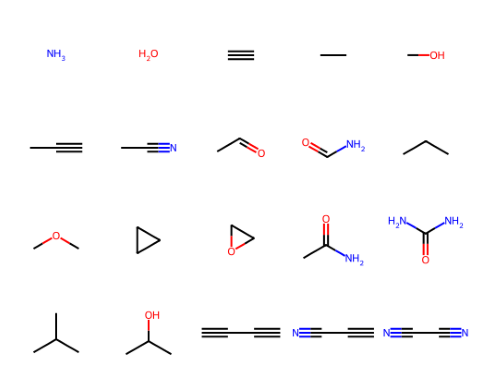

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

smiles_list = molecule_data['smiles'].values[0:20]
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
figure = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(100, 100), returnPNG=False)

plt.imshow(figure)
plt.axis('off')
plt.show()

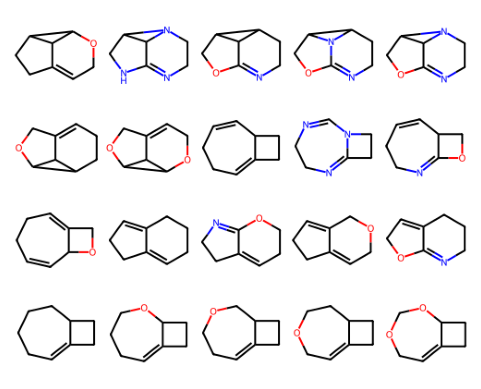

In [12]:
smiles_list = molecule_data['smiles'].values[31650:31670]
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
figure = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(100, 100), returnPNG=False)

plt.imshow(figure)
plt.axis('off')
plt.show()

Let's define some functions which help us to convert deep-smiles into a one-hot representation and normalise the property values.

In [13]:
def smiles_to_onehot(deep_smiles):

    max_len = max([len(x) for x in deep_smiles])
    data = []

    for item in deep_smiles:
        ch_lst = list(item) + (max_len - len(item)) * [stop_character]

        res = []

        for ch in ch_lst:
            r = [0] * len(chars)
            r[chars.index(ch)] = 1
            res.append(r)

        data.append(res)

    return data


def one_hot_to_smiles(data, chars, stop_character):

    res = []

    for item in data:
        ch_lst = []

        for ch in item:
            ch_lst.append(chars[np.argmax(ch)])

        res.append(''.join(ch_lst).split(stop_character)[0])

    return res


def sparse_to_smiles(data):

    res = []

    for item in data:
        ch_lst = []

        for ch in item:
            ch_lst.append(chars[ch[0]])

        res.append(''.join(ch_lst))

    return res

First, we shuffel the data.

In [14]:
molecule_data = molecule_data.sample(frac=1, random_state=123)

Then, we use our function to convert deep smiles to a one-hot representation

In [15]:
stop_character = 'x'

chars = sorted(list(set(''.join(molecule_data['deep_smiles'].values))))
chars = chars + [stop_character]

print('Unique characters:', chars)

data = smiles_to_onehot(molecule_data['deep_smiles'].values)
data = np.array(data).reshape((len(data), 17, 15, 1)).astype(np.float32)

Unique characters: ['#', ')', '3', '4', '5', '6', '7', '8', '9', '=', 'C', 'F', 'N', 'O', 'x']


and normalise the property values

In [16]:
band_gap_mean = molecule_data['band_gap'].mean()
band_gap_std = molecule_data['band_gap'].std()
target = (molecule_data['band_gap'] - band_gap_mean) / band_gap_std
target = target.values.reshape((len(data), 1)).astype(np.float32)

As usual, we split the dataset into training, validation, and test sets.

In [17]:
num_train = 28000
num_val = 1000
num_test = 1000

x_train = data[:num_train]
y_train = target[:num_train]

x_val = data[num_train:num_train + num_val]
y_val = target[num_train:num_train + num_val]

x_test = data[num_train + num_val:num_train + num_val + num_test]
y_test = target[num_train + num_val:num_train + num_val + num_test]

We can now create our new model ```CVAE``` which provides property predictions.

In [18]:
import tensorflow as tf
from tensorflow import keras

class CVAE(keras.Model):

    def __init__(self, latent_dim, batch_size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.encoder = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(17, 15, 1)),
                keras.layers.Flatten(),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(latent_dim,)),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(units=255),
                keras.layers.Reshape(target_shape=(17, 15, 1)),
            ]
        )
        
        # Our new decoder:
        self.decoder_property = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(latent_dim,)),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(units=1120, activation='relu'),
                keras.layers.Dense(units=1),
            ]
        )

    def call(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)

    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x, y):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    # Property

    y_pred = model.decoder_property(z)
    y_mse = -tf.reduce_mean(tf.square(y - y_pred), axis = 0)

    return -tf.reduce_mean(100 * y_mse + logpx_z + logpz - logqz_x)


def compute_y_mae(model, x, y):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    y_pred = model.decoder_property(z)
    y_mae = tf.reduce_mean(tf.abs(y - y_pred), axis = 0)
    return y_mae


@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

With this, we can now set the hyperparameters and create our model and optimiser.

In [19]:
learning_rate = 0.0001
batch_size = 100
num_epochs = 31
latent_dim = 14

optimizer = keras.optimizers.Adam(learning_rate)
model = CVAE(latent_dim, batch_size)

You can try to train this model:

In [ ]:
for epoch in range(1, num_epochs + 1):

    # Training steps
    for i in range(num_train // batch_size):
        train_step(model, x_train[i:i + batch_size], y_train[i:i + batch_size], optimizer)

    # Validation steps
    r_val = num_val // batch_size
    loss = keras.metrics.Mean()
    elbo = 0
    y_loss = 0

    for i in range(r_val):
        loss(compute_loss(model, x_val[i:i + batch_size], y_val[i:i + batch_size]))
        y_loss += compute_y_mae(model, x_val[i:i + batch_size], y_val[i:i + batch_size]).numpy()[0]
        elbo += -loss.result()

    elbo /= r_val
    y_loss = y_loss / r_val * band_gap_std * 627

    # Print validation results
    print(f'Epoch: {epoch}/{num_epochs}, validation loss (ELBO): {elbo}, Y MAE: {y_loss}')
    
    if epoch % 10:
        path = 'output/Molecules_VAE.h5'
        model.save_weights(path, save_format='h5')

Alternatively, you can just load the pretrained model here:

In [21]:
model = CVAE(latent_dim, num_test)
model(x_test)

# Our pretrained model (31 epochs):
model.load_weights('output/Molecules_VAE_pretrained.h5')

# ... or load your model:
# model.load_weights('output/Molecules_VAE.h5')

We can now make predictions with our model and use PCA for dimensionality reduction in order to visualise the latent space.

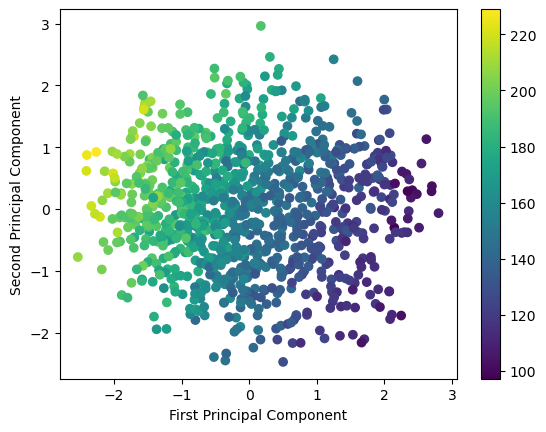

In [22]:
from sklearn.decomposition import PCA

mean_z, logvar_z = model.encode(x_test)
latent_z = model.reparameterize(mean_z, logvar_z)
target_pred = model.decoder_property(latent_z).numpy().flatten()

# Invert the scaling and convert the property unit to Kcal/mol
target_pred = (target_pred * band_gap_std + band_gap_mean) * 627

data_pca = PCA(n_components=2)
data_pca.fit(mean_z.numpy())
data_pca_transform = data_pca.transform(mean_z.numpy())

plt.scatter(data_pca_transform[:, 0], data_pca_transform[:, 1], c=target_pred)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

In this plot we can see a **smooth transition of the property correspondence making it easy to sample molecules of our interest**. To this end, we can linearly interpolate between two molecules. 

Let us pick $1000$ datapoints in the latent space.

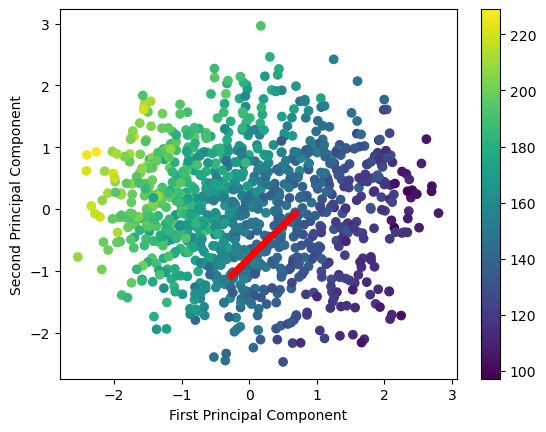

In [23]:
num_inter_data = 1000

latent_z_inter = np.linspace(mean_z[7:8][0], mean_z[8:9][0], num_inter_data)
latent_z_inter_transform = data_pca.transform(latent_z_inter)

plt.scatter(data_pca_transform[:, 0], data_pca_transform[:, 1], c=target_pred)
plt.colorbar()

plt.scatter(latent_z_inter_transform[:, 0], latent_z_inter_transform[:, 1], 
            marker='.', c='red')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()

We can now take these latent datapoints and decode molecules and their corresponding property value.

In [24]:
data_inter_pred = model.decoder(latent_z_inter)
target_inter_pred = model.decoder_property(latent_z_inter).numpy()

deep_smi_inter_pred = sparse_to_smiles(tf.argmax(data_inter_pred, axis=2).numpy())
deep_smi_inter_pred = [item.replace(stop_character, '') for item in deep_smi_inter_pred]

deep_smi_inter_pred, idx = np.unique(deep_smi_inter_pred, return_index=True)

# Invert the scaling and convert the property unit to Kcal/mol
target_inter_pred = (target_inter_pred[idx] * band_gap_std + band_gap_mean) * 627

Parse generated molecules and sort out invalid samples.

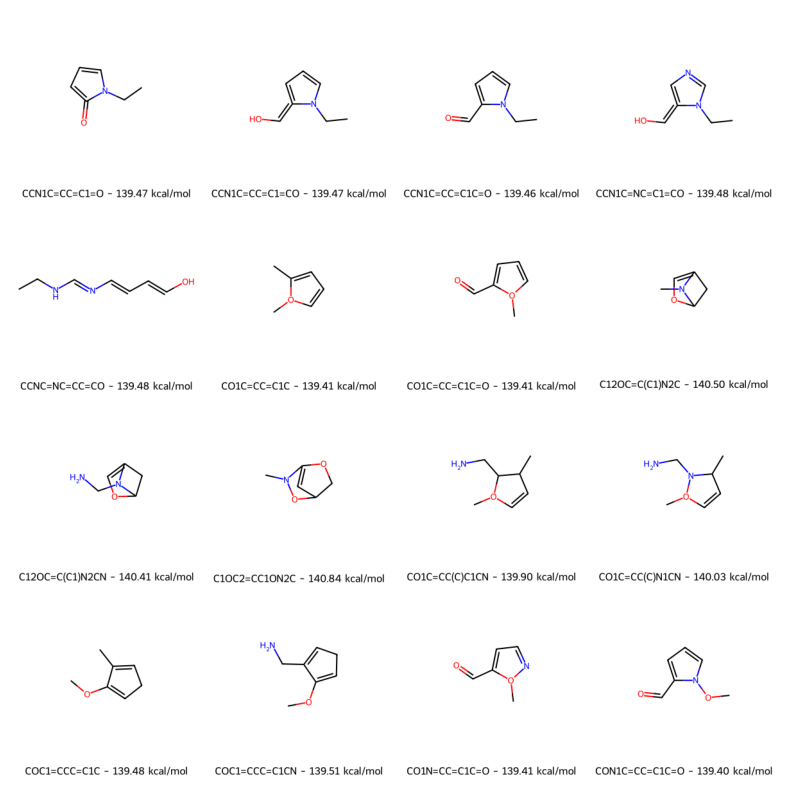

In [25]:
import deepsmiles

converter = deepsmiles.Converter(rings=True, branches=True)

molecule_list = []
labels = []

for i, item in enumerate(deep_smi_inter_pred):
    try:
        smi = converter.decode(item)
        mol = Chem.MolFromSmiles(smi, sanitize = False)
        
        if mol is not None:
            molecule_list.append(mol)
            p = target_inter_pred[i][0]
            labels.append(f'{smi} - {p:.2f} kcal/mol')
    except:
        pass

figure = Draw.MolsToGridImage(molecule_list, legends=labels, molsPerRow=4, subImgSize=(300, 300), returnPNG=False)

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis('off')
plt.show()